In [1]:
import os
import re
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def show_results(file_name, title, remove_first=False, set_axis=False, metric='mAP'):
    full_file_name = os.path.join(
        '/data/OnlineActionRecognition/source/outputs', file_name)

    loss = {'Train': [], 'Val': []}
    mAP = {'Train': [], 'Val': []}
    jump_next_line = False
    weight_decay = None
    learning_weight = None
    batch_size = None
    hvd_num = None
    with open(full_file_name, 'r') as file:
        for line in file:
            if 'INFO' in line:
                if 'Epoch' in line:
                    jump_next_line = True
                continue
            if jump_next_line:
                jump_next_line = False
                continue
                
            matches = re.search('(Train|Val): loss = (\d*.\d*), {} = (\d*.\d*).'.format(metric), line)
            
            if matches:
                mode, l, m = matches.groups()
                loss[mode].append(float(l))
                mAP[mode].append(float(m))
            elif 'Weight decay:' in line:
                weight_decay = line
            elif 'Learning rate configuration:' in line:
                learning_weight = line
            elif 'Batch size:' in line:
                batch_size = line
            elif 'horovod processes' in line:
                hvd_num = line
                
    if remove_first:
        loss['Train'] = loss['Train'][1:]
        loss['Val'] = loss['Val'][1:]
        mAP['Train'] = mAP['Train'][1:]
        mAP['Val'] = mAP['Val'][1:]

    x = range(1, len(loss['Train'])+1)
     
    fig = plt.figure(figsize=(15,5))
    fig.suptitle(title)

    plt.subplot(121)
    plt.plot(x, loss['Train'], 'ro-', label='Train')
    plt.plot(x, loss['Val'], 'go-', label='Val')
    if set_axis:
        plt.ylim(0, max([0.7, max(loss['Train'])+0.05, max(loss['Val'])+0.05]))
    plt.ylabel('Loss')
    plt.xlabel('epochs')
    plt.legend()

    plt.subplot(122)
    plt.plot(x, mAP['Train'], 'ro-', label='Train')
    plt.plot(x, mAP['Val'], 'go-', label='Val')
    if set_axis:
        plt.ylim(top=40)
    plt.axhline(max(mAP['Train']), linestyle='--', color='b')
    plt.axhline(max(mAP['Val']), linestyle='--', color='y')
    
    l, r = plt.xlim()
    plt.text(r+.5, max(mAP['Train']), max(mAP['Train']), va='center', ha="left", bbox=dict(facecolor="w",alpha=0.5))
    plt.text(r+.5, max(mAP['Val']), max(mAP['Val']), va='center', ha="left", bbox=dict(facecolor="w",alpha=0.5))
    
    plt.ylabel('mAP')
    plt.xlabel('epochs')
    plt.legend()

    plt.show()
    

    print('{}{}{}{}'.format(
        batch_size, weight_decay, learning_weight, hvd_num))
    print('---------------------------------------------------------------------------------------------------------------\n')
    
    

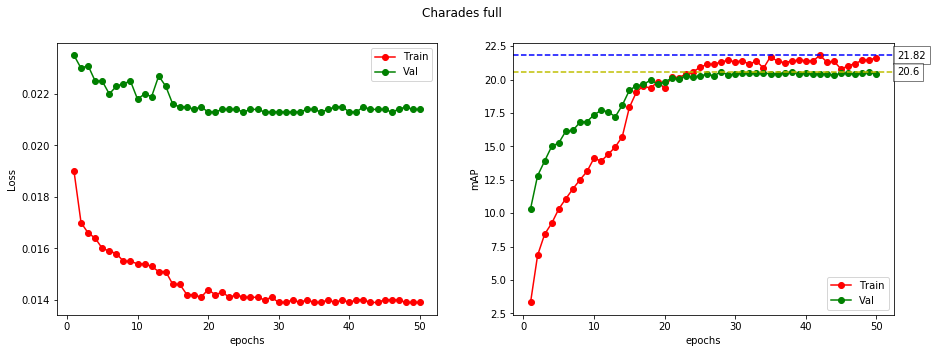

Batch size: 5
Weight decay: 1e-07
Learning rate configuration: {'type': 'reduce_lr', 'params': {'initial_lr': 0.375}}
Using 4 horovod processes

---------------------------------------------------------------------------------------------------------------



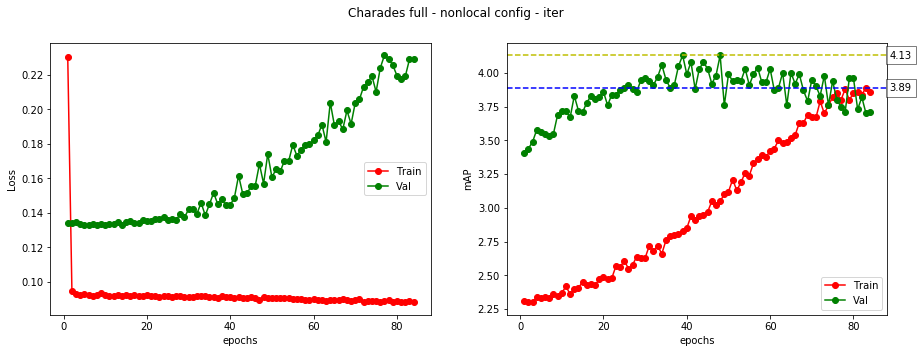

Batch size: 1 (per GPU)
Weight decay: 0.0001
Learning rate configuration: {'type': 'lambda_lr', 'params': {'initial_lr': 0.001, 'step_per_iter': True, 'learning_rate': [[75000, 0.00125], [75000, 0.000125], [50000, 1.25e-05]]}}
Using 8 horovod processes

---------------------------------------------------------------------------------------------------------------



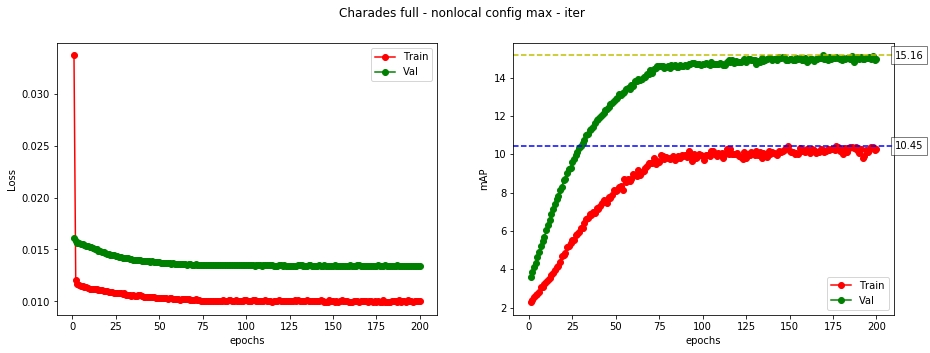

Batch size: 8 (per GPU)
Weight decay: 0.0001
Learning rate configuration: {'type': 'lambda_lr', 'params': {'step_per_iter': True, 'learning_rate': [[9375, 0.01], [9375, 0.001], [6250, 0.0001]]}}
Using 8 horovod processes

---------------------------------------------------------------------------------------------------------------



In [5]:
show_results('charades_config4-v1_full.log', title='Charades full')
show_results('charades_orig_config_iter_full.log', title='Charades full - nonlocal config - iter')
show_results('charades_orig_config_max_iter_full.log', title='Charades full - nonlocal config max - iter')

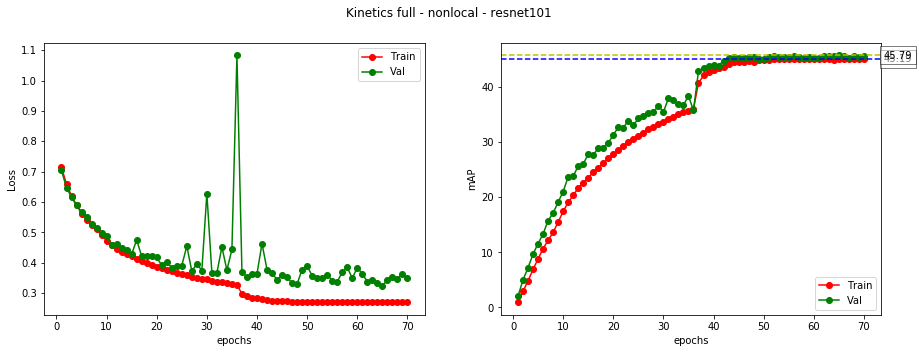

Batch size: 8
Weight decay: 0.0001
Learning rate configuration: 0.01
Using 8 horovod processes

---------------------------------------------------------------------------------------------------------------



In [4]:
show_results('kinetics_resnet101_nonlocal32_full.log', title='Kinetics full - nonlocal - resnet101', metric='accuracy')